In [1]:
import itk
import matplotlib.pyplot as plt
import requests
import os

In [2]:
%matplotlib notebook

In [3]:
# Download Etioplast image from Chris Woodcock,
# http://www.cellimagelibrary.org/images/684
filepath = '684.tif'
if not os.path.exists(filepath):
    url = 'http://grackle.crbs.ucsd.edu:8080/OmeroWebService/images/684.tif'
    request = requests.get(url)
    with open(filepath, 'wb') as fp:
        fp.write(request.content)

In the center of the figure is an [etioplast, with prolamellar bodies,](http://www.cellimagelibrary.org/images/684#download_options_button) the [lattice of spherical structures at the center of the etioplast](https://www.researchgate.net/publication/226671748_The_Diversity_of_Plastid_Form_and_Function/figures), with thylakoid membranes extending. The dark circular structures are [osmiophilic globules](http://www.cellimagelibrary.org/images/39077).

In [4]:
Dimension = 2
PixelType = itk.ctype('float')
ImageType = itk.Image[PixelType, Dimension]
reader = itk.ImageFileReader[ImageType].New(FileName=filepath)
reader.Update()
image = reader.GetOutput()
print(image)

Image (0x3c87930)
  RTTI typeinfo:   itk::Image<float, 2u>
  Reference Count: 2
  Modified Time: 151
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (0x3cc1fd0) 
  Source output name: Primary
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 18
  UpdateMTime: 152
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [4183, 2804]
  BufferedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [4183, 2804]
  RequestedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [4183, 2804]
  Spacing: [1, 1]
  Origin: [0, 0]
  Direction: 
1 0
0 1

  IndexToPointMatrix: 
1 0
0 1

  PointToIndexMatrix: 
1 0
0 1

  Inverse Direction: 
1 0
0 1

  PixelContainer: 
    ImportImageContainer (0x3c87ae0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Modified Time: 149
      Debug: Off
      Object Name: 
      Observers: 
        none
      Pointer: 0x7f4

<IPython.core.display.Javascript object>


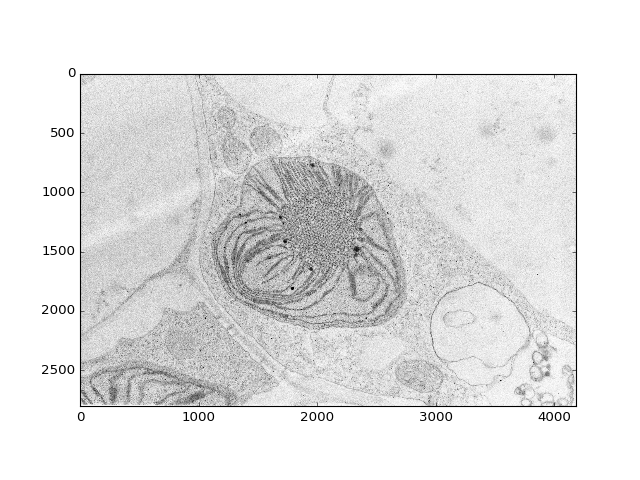

In [5]:
plt.figure(1)
plt.imshow(itk.GetArrayViewFromImage(image), cmap='gray', vmin=20000)

In [6]:
import itkConfig
import uuid
_tqdm_notebook_bar = {}
try:
    from tqdm import tqdm_notebook
    def tqdm_notebook_callback(name, progress):
        """Display progress in a Jupyter notebook with a tqdm widget
        
        This function can be used with itkConfig.ProgressCallback"""
        global _tqdm_notebook_bar
        if progress == 0:
            _tqdm_notebook_bar = tqdm_notebook(total=1000)
        _tqdm_notebook_bar.set_description(name)
        _tqdm_notebook_bar.update(int(100000*progress) - _tqdm_notebook_bar.n)
        if progress == 1:
            _tqdm_notebook_bar.close()
    #itkConfig.ProgressCallback = tqdm_notebook_callback
            
except ImportError:
    pass
print(itkConfig.ProgressCallback)

None


In [6]:
# Crop to region of interest
roi_filter = itk.RegionOfInterestImageFilter.New(image)
region = itk.ImageRegion[Dimension]()
index = itk.Index[Dimension]()
index[0] = 900
index[1] = 400
region.SetIndex(index)
size = itk.Size[Dimension]()
size[0] = 2200
size[1] = 2000
region.SetSize(size)
roi_filter.SetRegionOfInterest(region)
roi_filter.Update()
roi = roi_filter.GetOutput()

<IPython.core.display.Javascript object>


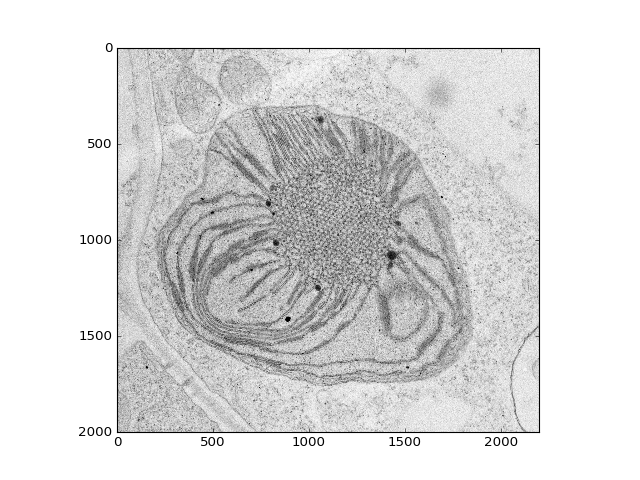

In [7]:
plt.figure(2)
plt.imshow(itk.GetArrayViewFromImage(roi), cmap='gray', vmin=20000)

In [8]:
# Crop to small region of interest to experiment with smoothing parameters
small_roi_filter = itk.RegionOfInterestImageFilter.New(image)
region = itk.ImageRegion[Dimension]()
index = itk.Index[Dimension]()
index[0] = 1500
index[1] = 1250
region.SetIndex(index)
size = itk.Size[Dimension]()
size[0] = 400
size[1] = 400
region.SetSize(size)
small_roi_filter.SetRegionOfInterest(region)
small_roi_filter.Update()
small_roi = small_roi_filter.GetOutput()

<IPython.core.display.Javascript object>


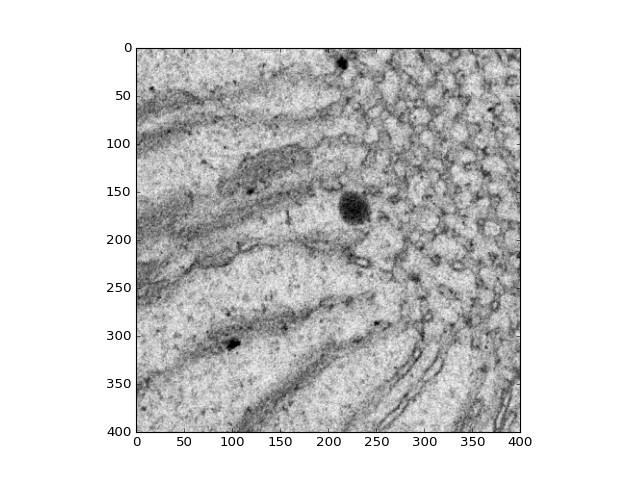

In [9]:
plt.figure(3)
plt.imshow(itk.GetArrayViewFromImage(small_roi), cmap='gray', vmin=20000)

In [10]:
smoother = itk.CoherenceEnhancingDiffusionImageFilter.New(roi)
# Determine good parameters here: https://insightsoftwareconsortium.github.io/ITKAnisotropicDiffusionLBR/
smoother.SetDiffusionTime(3.5)
smoother.SetLambda(0.1)
smoother.SetEnhancement(3)
smoother.SetNoiseScale(3)
smoother.SetFeatureScale(5)
smoother.SetExponent(3.5)
smoother.Update()

<IPython.core.display.Javascript object>


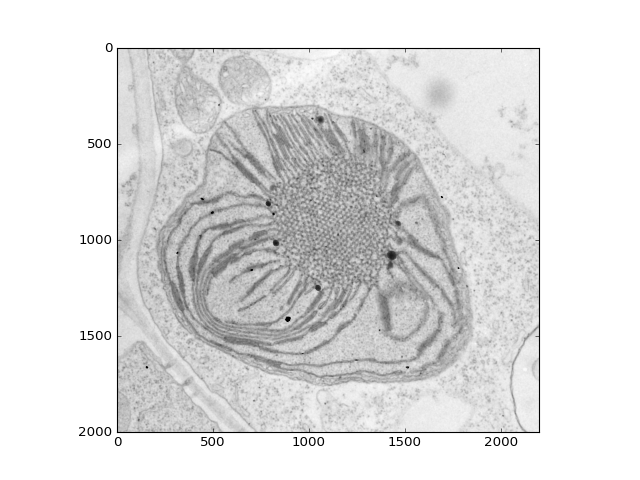

In [11]:
plt.figure(4)
plt.imshow(itk.GetArrayViewFromImage(smoother.GetOutput()), cmap='gray', vmin=20000)

In [18]:
IntPixelType = itk.ctype('signed short')
IntImageType = itk.Image[IntPixelType, Dimension]
caster = itk.RescaleIntensityImageFilter[ImageType, IntImageType].New(smoother)
caster.Update()

<IPython.core.display.Javascript object>


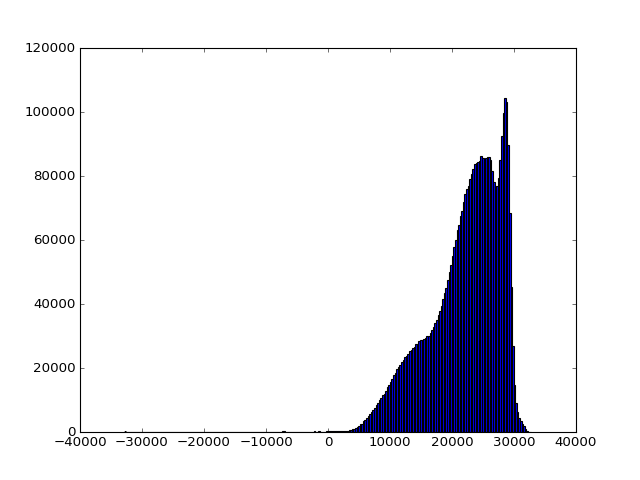

In [19]:
plt.figure(5)
plt.hist(itk.GetArrayViewFromImage(caster.GetOutput()).ravel(), bins=256);

In [126]:
FeaturesImageType = itk.VectorImage[itk.ctype('float'), Dimension]
coocurrence = itk.CoocurrenceTextureFeaturesImageFilter[IntImageType, FeaturesImageType].New(caster)
coocurrence.SetPixelValueMinMax(0, 32000)
coocurrence.SetNumberOfBinsPerAxis(10)
coocurrence.SetNeighborhoodRadius([8,8])
%time coocurrence.Update()

CPU times: user 2min 39s, sys: 100 ms, total: 2min 39s
Wall time: 21.5 s


<IPython.core.display.Javascript object>


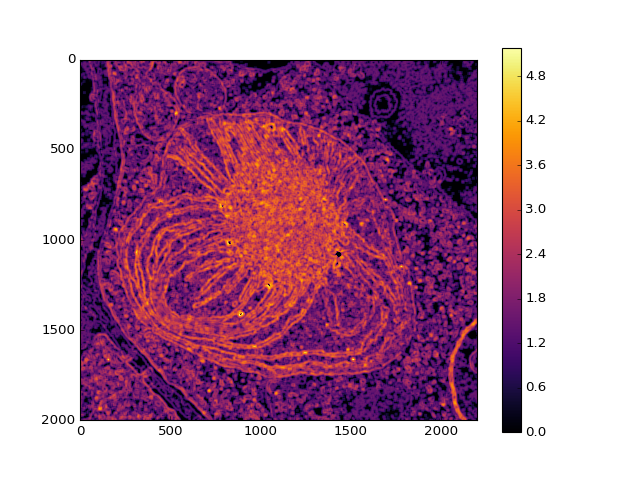

(2000, 2200, 8)


In [136]:
plt.figure(6)
print(itk.GetArrayViewFromImage(coocurrence.GetOutput()).shape)
plt.imshow(itk.GetArrayViewFromImage(coocurrence.GetOutput())[:,:,1], cmap='inferno', vmin=None, vmax=None)
plt.colorbar()

In [137]:
FeaturesImageType = itk.VectorImage[itk.ctype('float'), Dimension]
runlength = itk.RunLengthTextureFeaturesImageFilter[IntImageType, FeaturesImageType].New(caster)
runlength.SetPixelValueMinMax(0, 32000)
runlength.SetDistanceValueMinMax(0, 8.0)
runlength.SetNumberOfBinsPerAxis(10)
runlength.SetNeighborhoodRadius([8,8])
%time runlength.Update()

CPU times: user 4min 48s, sys: 92 ms, total: 4min 48s
Wall time: 38.3 s


<IPython.core.display.Javascript object>


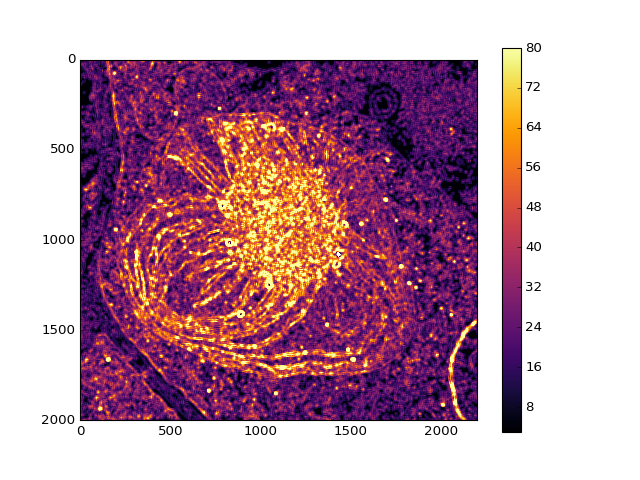

(2000, 2200, 10)


In [152]:
plt.figure(7)
print(itk.GetArrayViewFromImage(runlength.GetOutput()).shape)
plt.imshow(itk.GetArrayViewFromImage(runlength.GetOutput())[:,:,3], cmap='inferno', vmin=None, vmax=80)
plt.colorbar()

In [175]:
component = itk.VectorIndexSelectionCastImageFilter.New(runlength)
component.SetIndex(3)
thresholder = itk.BinaryThresholdImageFilter.New(component)
thresholder.SetLowerThreshold(40)
thresholder.Update()

<IPython.core.display.Javascript object>


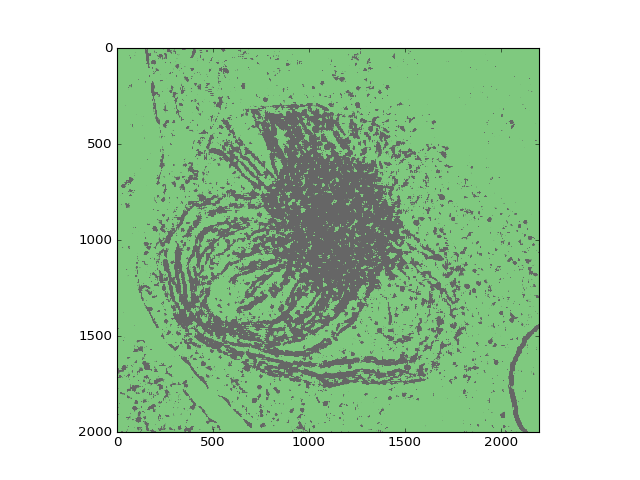

In [181]:
plt.figure(8)
plt.imshow(itk.GetArrayViewFromImage(thresholder), cmap='Accent')

In [ ]:
plt.figure(7)
plt.imshow(itk.GetArrayViewFromImage(fillhole.GetOutput()))

In [ ]:
signed_distance = itk.SignedMaurerDistanceMapImageFilter.New(fillhole)
signed_distance.SetInsideIsPositive(True)
signed_distance.Update()

In [ ]:
plt.figure(8)
plt.imshow(itk.GetArrayViewFromImage(signed_distance.GetOutput()))

In [ ]:
level_set = itk.ThresholdSegmentationLevelSetImageFilter.New(signed_distance)
level_set.SetFeatureImage(smoother)
level_set.SetPropagationScaling(1.0)
level_set.SetCurvatureScaling(2000.0)
level_set.SetMaximumRMSError(0.005)
level_set.SetMaximumIterations(8000)
level_set.SetUpperThreshold(55000)
level_set.SetLowerThreshold(0)
level_set.SetIsoSurfaceValue(-200.)
level_set.Update()
print(level_set.GetElapsedIterations())
print(level_set.GetRMSChange())

In [ ]:
fig = plt.figure(9, figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(itk.GetArrayViewFromImage(smoother), cmap='gray', vmin=20000)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(itk.GetArrayViewFromImage(level_set.GetOutput()))

In [ ]:
plt.figure(7)
plt.imshow(itk.GetArrayViewFromImage(gray.GetOutput()), cmap='gray', vmin=20000)

# gray.SetRadius?

In [ ]:
plt.figure(10)
plt.imshow(itk.GetArrayViewFromImage(smoother.GetOutput()) > 57000)

In [ ]:
grad.SetAlgorithm?